**CURSO**: Machine Learning, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources, mainly from [scikit-learn1](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py), [sciki-learn2](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py), [sciki-learn3](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Gaussian Processes

In [1]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

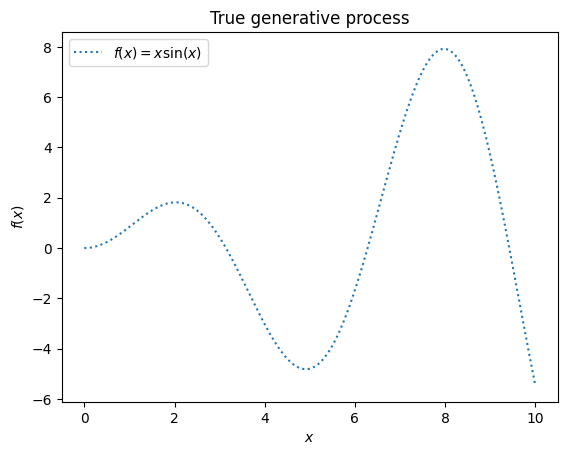

In [2]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

### Example with noise-free target¶

In [3]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

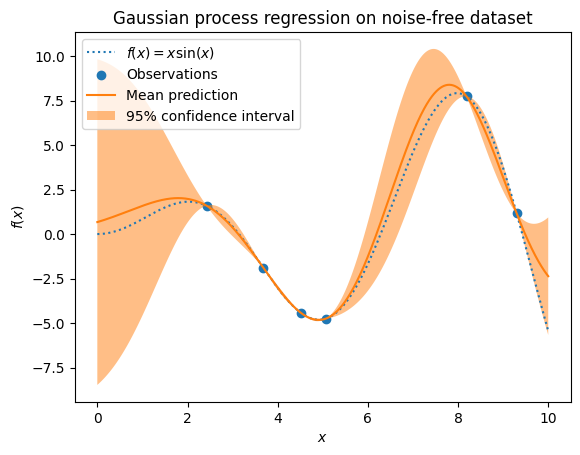

In [5]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

### Example with noisy targets¶


In [7]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [8]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

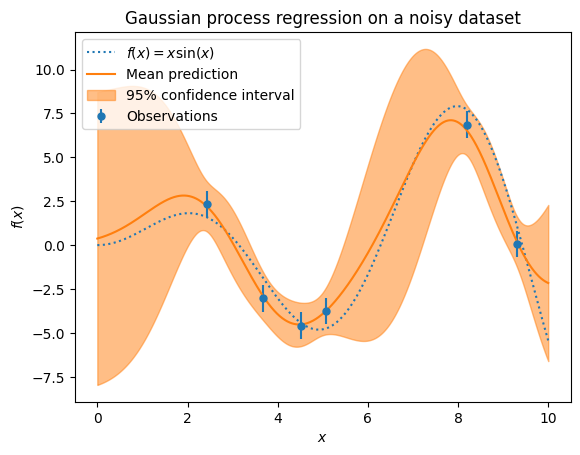

In [9]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

### Comparison of kernel ridge and Gaussian process regression¶

In [13]:
rng = np.random.RandomState(0)
X = np.linspace(0, 30, num=1_000).reshape(-1, 1)
y = np.sin(X).ravel()

In [16]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_X = X[training_sample_indices]
training_noisy_y = y[training_sample_indices] + 0.5 * rng.randn(len(training_sample_indices))

Text(0, 0.5, 'target')

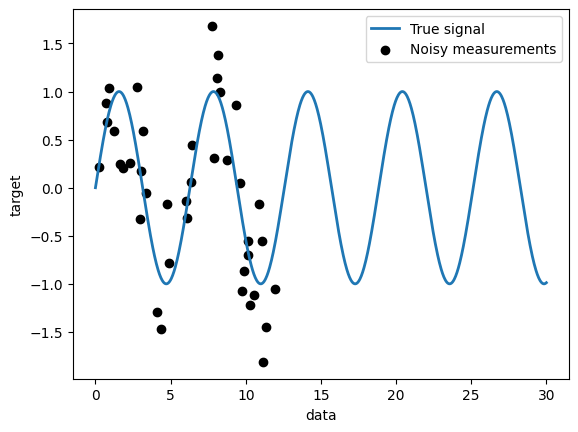

In [17]:
plt.plot(X, y, label="True signal", linewidth=2)
plt.scatter(training_X,training_noisy_y,color="black",label="Noisy measurements",)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")

Text(0, 0.5, 'target')

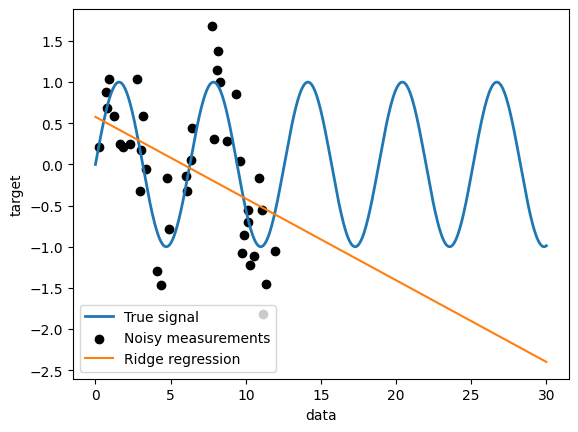

In [19]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_X, training_noisy_y)

plt.plot(X, y, label="True signal", linewidth=2)
plt.scatter(training_X,training_noisy_y,color="black",label="Noisy measurements",)
plt.plot(X, ridge.predict(X), label="Ridge regression")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")

#### Kernel ridge

We can make the previous linear model more expressive by using a so-called kernel. A kernel is an embedding from the original feature space to another one. Simply put, it is used to map our original data into a newer and more complex feature space. This new space is explicitly defined by the choice of kernel.

In our case, we know that the true generative process is a periodic function. We can use a ExpSineSquared kernel which allows recovering the periodicity. The class KernelRidge will accept such a kernel.

Using this model together with a kernel is equivalent to embed the data using the mapping function of the kernel and then apply a ridge regression. In practice, the data are not mapped explicitly; instead the dot product between samples in the higher dimensional feature space is computed using the “kernel trick”.

In [20]:
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())
kernel_ridge.fit(training_X, training_noisy_y)

KernelRidge(kernel=ExpSineSquared(length_scale=1, periodicity=1))

Text(0, 0.5, 'target')

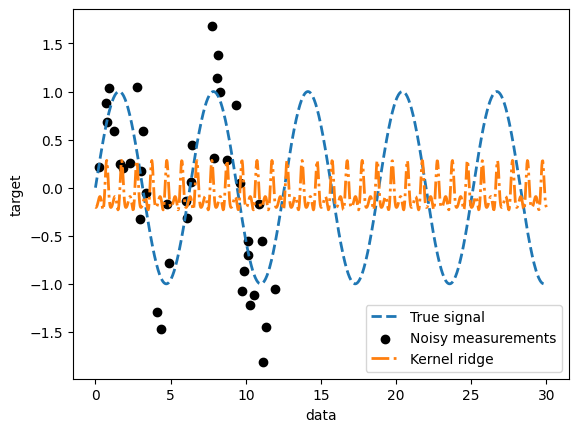

In [23]:
plt.plot(X, y, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(training_X,training_noisy_y,color="black",label="Noisy measurements",)
plt.plot(X,kernel_ridge.predict(X),label="Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")

In [24]:
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

In [26]:
from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {"alpha": loguniform(1e0, 1e3),"kernel__length_scale": loguniform(1e-2, 1e2),"kernel__periodicity": loguniform(1e0, 1e1),}
kernel_ridge_tuned = RandomizedSearchCV(kernel_ridge,param_distributions=param_distributions,n_iter=500,random_state=0,)
kernel_ridge_tuned.fit(training_X, training_noisy_y)

RandomizedSearchCV(estimator=KernelRidge(kernel=ExpSineSquared(length_scale=1, periodicity=1)),
                   n_iter=500,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002380473E410>,
                                        'kernel__length_scale': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002380473F650>,
                                        'kernel__periodicity': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023804744490>},
                   random_state=0)

In [27]:
kernel_ridge_tuned.best_params_

{'alpha': 1.991584977345022,
 'kernel__length_scale': 0.7986499491396734,
 'kernel__periodicity': 6.6072758064261095}

In [28]:
predictions_kr = kernel_ridge_tuned.predict(X)

Text(0, 0.5, 'target')

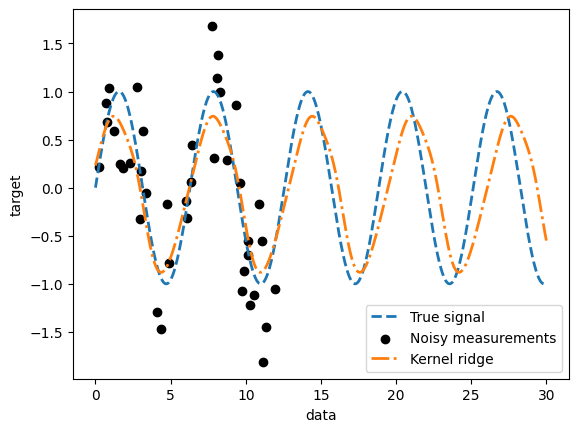

In [30]:
plt.plot(X,y, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(training_X,training_noisy_y,color="black",label="Noisy measurements",)
plt.plot(X,predictions_kr,label="Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")

#### Gaussian process regression¶

In [31]:
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_X, training_noisy_y)

GaussianProcessRegressor(kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=5) + WhiteKernel(noise_level=0.1))

In [32]:
gaussian_process.kernel_

0.962**2 * ExpSineSquared(length_scale=1.72, periodicity=6.37) + WhiteKernel(noise_level=0.247)

In [33]:
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(X,return_std=True,)

Text(0, 0.5, 'target')

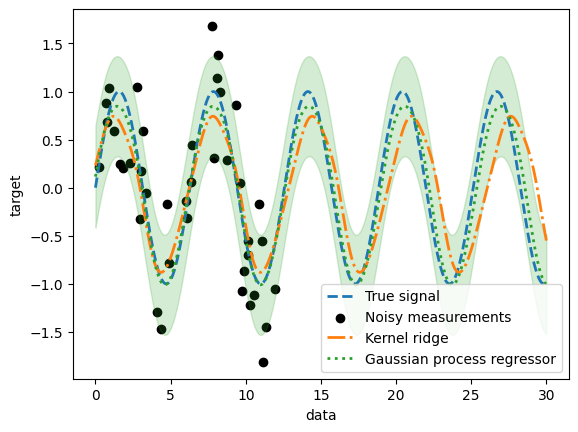

In [35]:
plt.plot(X,y, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(training_X,training_noisy_y,color="black",label="Noisy measurements",)
plt.plot(X,predictions_kr,label="Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.plot(X,mean_predictions_gpr,label="Gaussian process regressor",linewidth=2,linestyle="dotted",)
plt.fill_between(X.ravel(),mean_predictions_gpr - std_predictions_gpr,mean_predictions_gpr + std_predictions_gpr,color="tab:green",alpha=0.2,)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")

#### Estimate data noise-level

In [36]:
def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

In [37]:
X = np.linspace(0, 5, num=30).reshape(-1, 1)
y = target_generator(X, add_noise=False)

Text(0.5, 0, 'X')

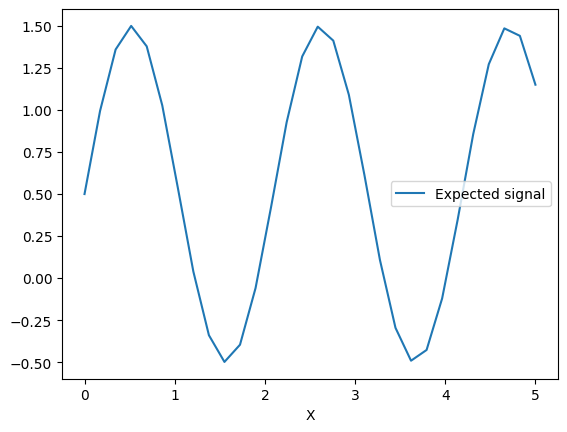

In [38]:
plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")

In [39]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

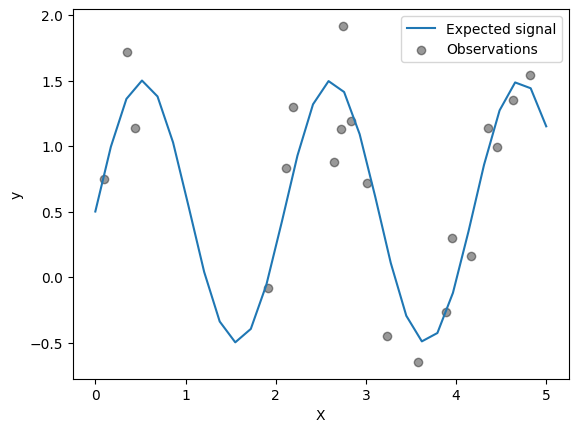

In [40]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0],y=y_train,color="black",alpha=0.4,label="Observations",)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

In [41]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

C:\Users\edier\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'y')

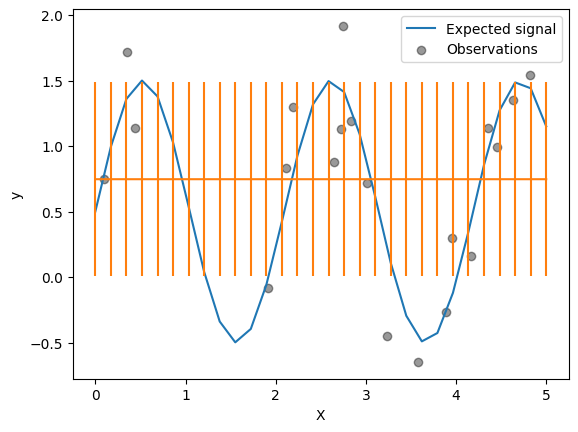

In [42]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")

In [43]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

Text(0, 0.5, 'y')

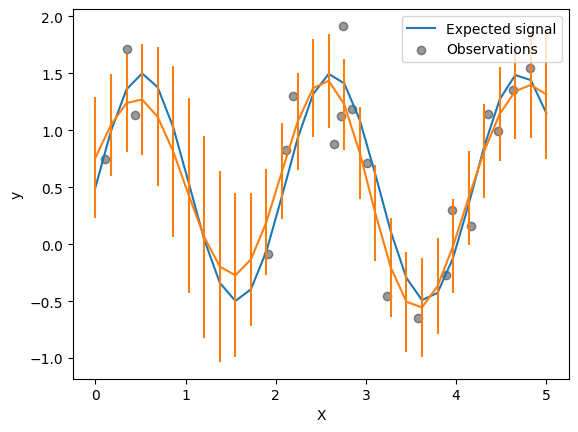

In [44]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")